Podstawowy przepływ pracy uczenia maszynowego:
1. Przygotowanie danych: zbadanie zbioru i przygotowanie do dalszych kroków
2. Budowa potoku wejściowego
3. Budowa modelu
4. Trenowanie modelu
5. Przetestowanie modelu
6. Poprawki w modelu i powtórzenie procesu

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
import pathlib

In [4]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos',origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228813984/228813984 [==============================] - 7s 0us/step


In [5]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


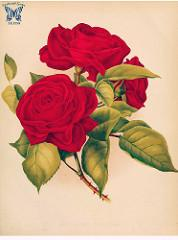

In [6]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

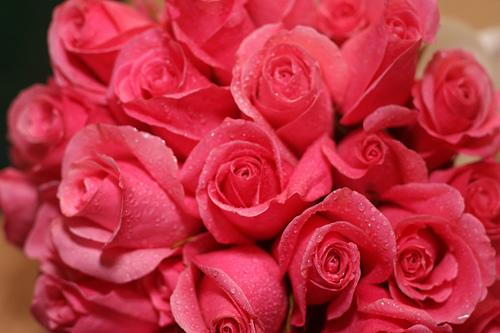

In [7]:
PIL.Image.open(str(roses[1]))

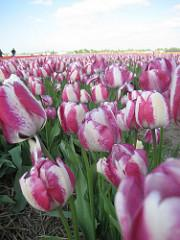

In [8]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

Załaduj dane!
parametry modułu ładującego

In [9]:
batch_size= 32
img_height = 180
img_width = 180

In [10]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [11]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [12]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


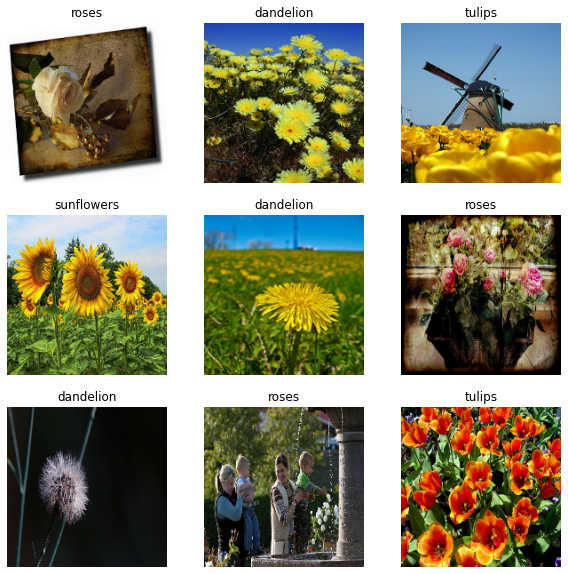

In [13]:
plt.figure(figsize=(10,10))
for images,labels in train_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [15]:
#konfiguracja zbioru danych pod kątem wydajności
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [16]:
#standaryzacja danych
normalization_layer = layers.Rescaling(1./255)

In [17]:
normalized_ds = train_ds.map(lambda x,y:(normalization_layer(x),y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image),np.max(first_image))

1.8150287e-05 0.9993029


In [18]:
#Tworzenie modelu
num_classes = len(class_names)
model = Sequential([
    layers.Rescaling(1./255,input_shape=(img_height,img_width,3)),
    layers.Conv2D(16,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(num_classes)
]
)

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [21]:
epochs=10
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs)

Epoch 1/10
92/92 [==============================] - 70s 739ms/step - loss: 1.4436 - accuracy: 0.3862 - val_loss: 1.1290 - val_accuracy: 0.5191
Epoch 2/10
92/92 [==============================] - 75s 814ms/step - loss: 1.0382 - accuracy: 0.5899 - val_loss: 1.0019 - val_accuracy: 0.5940
Epoch 3/10
92/92 [==============================] - 133s 1s/step - loss: 0.8768 - accuracy: 0.6553 - val_loss: 0.9581 - val_accuracy: 0.6199
Epoch 4/10
92/92 [==============================] - 275s 3s/step - loss: 0.6663 - accuracy: 0.7473 - val_loss: 0.9249 - val_accuracy: 0.6703
Epoch 5/10
92/92 [==============================] - 293s 3s/step - loss: 0.4458 - accuracy: 0.8392 - val_loss: 0.9850 - val_accuracy: 0.6458
Epoch 6/10
92/92 [==============================] - 295s 3s/step - loss: 0.2807 - accuracy: 0.9036 - val_loss: 1.1239 - val_accuracy: 0.6485
Epoch 7/10
92/92 [==============================] - 280s 3s/step - loss: 0.1608 - accuracy: 0.9482 - val_loss: 1.4621 - val_accuracy: 0.6158
Epoch 8/1

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']


loss = history.history['loss']
val_loss = history.history['val_loss']

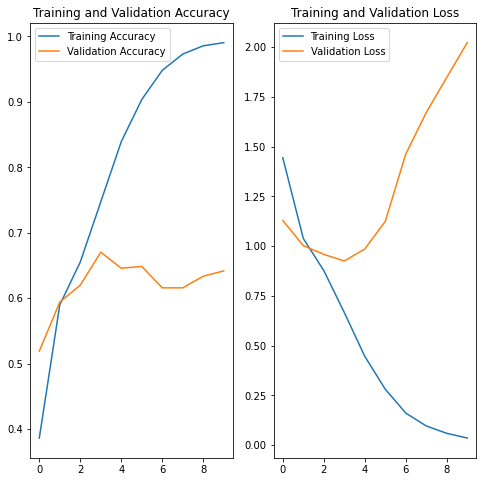

In [25]:
epochs_range = range(epochs)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range,acc,label='Training Accuracy')
plt.plot(epochs_range,val_acc,label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range,loss,label='Training Loss')
plt.plot(epochs_range,val_loss,label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()

In [26]:
#Overfitting - przetrenowanie modelu ze względu na niezbyt duży rozmiar zbioru danych

data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal',
                      input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

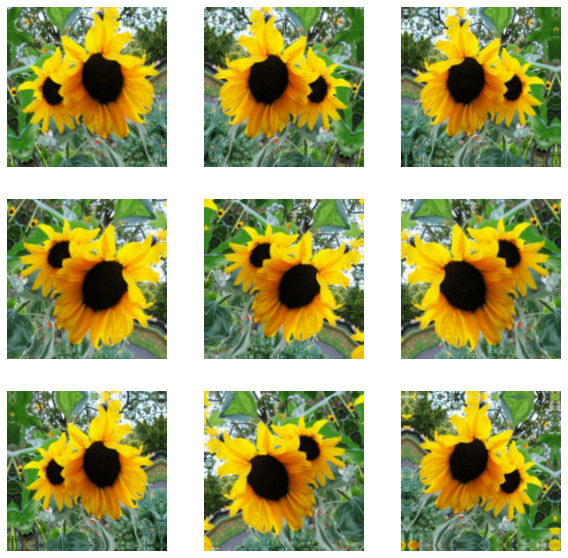

In [27]:
plt.figure(figsize=(10,10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3,3,i+1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [28]:
#model z dropout

model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(num_classes)
]
)

In [29]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [30]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [31]:
epochs = 15 
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs)

Epoch 1/15
92/92 [==============================] - 80s 825ms/step - loss: 1.2786 - accuracy: 0.4527 - val_loss: 1.2521 - val_accuracy: 0.5136
Epoch 2/15
92/92 [==============================] - 237s 3s/step - loss: 1.0478 - accuracy: 0.5743 - val_loss: 1.0531 - val_accuracy: 0.5858
Epoch 3/15
92/92 [==============================] - 282s 3s/step - loss: 0.9268 - accuracy: 0.6410 - val_loss: 1.0285 - val_accuracy: 0.5817
Epoch 4/15
92/92 [==============================] - 255s 3s/step - loss: 0.8507 - accuracy: 0.6642 - val_loss: 0.9721 - val_accuracy: 0.6253
Epoch 5/15
92/92 [==============================] - 249s 3s/step - loss: 0.8062 - accuracy: 0.6894 - val_loss: 0.8899 - val_accuracy: 0.6649
Epoch 6/15
92/92 [==============================] - 227s 2s/step - loss: 0.7485 - accuracy: 0.7200 - val_loss: 0.8338 - val_accuracy: 0.6608
Epoch 7/15
92/92 [==============================] - 224s 2s/step - loss: 0.7106 - accuracy: 0.7258 - val_loss: 0.7944 - val_accuracy: 0.6649
Epoch 8/15


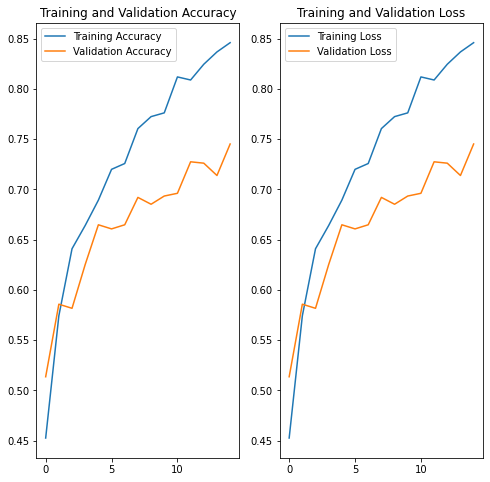

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']


loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range,acc,label='Training Accuracy')
plt.plot(epochs_range,val_acc,label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range,acc,label='Training Loss')
plt.plot(epochs_range,val_acc,label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()

In [33]:
#predykcja na danych niezależnych
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower',origin=sunflower_url)

img = tf.keras.utils.load_img(sunflower_path,target_size=(img_height,img_width))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array,0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(f"obraz prawodpobnie należy do kategorii: {class_names[np.argmax(score)]}, z prawdopodobieństwem {100*np.max(score)} procent")

1/1 [==============================] - 1s 908ms/step
obraz prawodpobnie należy do kategorii: sunflowers, z prawdopodobieństwem 97.42760062217712 procent
